In [1]:
from gwdistributions import parse, generators
import json
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import re
from tqdm import tqdm
import importlib
import inspect
from scipy.special import erf
import sys
import copy

def extract_equalities(file_path):
    equalities = {}
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            # Match only lines with variable assignments not inside function calls
            if "=" in line and not line.startswith("def") and "(" not in line and not line.startswith("lamda") and "guess_args" not in line:
                key_value = re.split(r'\s*=\s*', line, maxsplit=1)
                if len(key_value) == 2:
                    key, value = key_value
                    equalities[key.strip()] = value.strip()
    return equalities

def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

def pickle_read(path):
    import pickle
    with open(path + '_mcmc.obj', 'rb') as f:
        unpickler = pickle.Unpickler(f)
        object_pi2 = unpickler.load()
    return object_pi2

In [2]:
def get_variables(file_path, model_name=None):
    module_name = file_path.split("/")[-1].split(".")[0]
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    sys.modules[module_name] = module
    methods_info = {}

    # Requires function to have the same name as python file being imported.
    for name, obj in inspect.getmembers(module):
        if inspect.isfunction(obj) or inspect.ismethod(obj):
            if name != model_name:
                continue
            signature = inspect.signature(obj)
            parameters = list(signature.parameters.keys())
            methods_info[name] = parameters
    return module_name, methods_info[f"{model_name}"]


In [3]:
from jax.scipy.special import erf

# Matches Colm Talbot from gwpopulation
# https://github.com/ColmTalbot/gwpopulation/blob/main/gwpopulation/utils.py
def truncnorm_pdf(x, mu, sigma, a, b):
    """Compute the analytically normalized truncated normal PDF using JAX."""
    # Compute normalization constant Z
    alpha = (a - mu) / (xp.sqrt(2) * sigma)
    beta = (b - mu) / (xp.sqrt(2) * sigma)
    Z = 0.5 * sigma * xp.sqrt(2 * xp.pi) * (erf(beta) - erf(alpha))
    # Compute the unnormalized Gaussian PDF
    pdf_unnormalized = xp.exp(-0.5 * ((x - mu) / sigma) ** 2)
    # Normalize
    pdf = pdf_unnormalized / Z
    return xp.where((x >= a) & (x <= b), pdf, 1e-100)

def uniform_pdf(x, a, b):
    """Compute the uniform PDF using JAX."""
    return 1 / (b - a)

def prob_chi_single(a, mu_chi, sig_chi, a_min, a_max):
    p_chi = truncnorm_pdf(a, mu_chi, sig_chi, a_min, a_max)
    return p_chi

def prob_costilt_single(costilt, mix_tilt, sig_tilt, costilt_max, costilt_min):
    mix_temp1 = truncnorm_pdf(costilt, mu = 1, sigma=sig_tilt, a=costilt_min, b=costilt_max)
    mix_temp2 = uniform_pdf(costilt, costilt_min, costilt_max)
    p_costilt = mix_tilt * mix_temp1 + (1-mix_tilt) * mix_temp2
    return p_costilt

def prob_chi(a, m, mu_chi1, sig_chi1, mu_chi2, sig_chi2, m_spin_break, a_min, a_max, a_max_NS):
    p_chi_below = prob_chi_single(a, mu_chi1, sig_chi1, a_min, a_max_NS)
    p_chi_above = prob_chi_single(a, mu_chi2, sig_chi2, a_min, a_max)
    p_chi = xp.where(m < m_spin_break, p_chi_below, p_chi_above)
    return p_chi

def prob_costilt(costilt, m, mix_tilt1, sig_tilt1, mix_tilt2, sig_tilt2, m_spin_break, costilt_max, costilt_min):
    p_costilt_below = prob_costilt_single(costilt, mix_tilt1, sig_tilt1, costilt_max, costilt_min)
    p_costilt_above = prob_costilt_single(costilt, mix_tilt2, sig_tilt2, costilt_max, costilt_min)
    p_costilt = xp.where(m < m_spin_break, p_costilt_below, p_costilt_above)
    return p_costilt


def prob_spin_component(m, a, costilt,
                        mu_chi1, sig_chi1, mix_tilt1, sig_tilt1,
                        mu_chi2, sig_chi2, mix_tilt2, sig_tilt2,
                        m_spin_break,
                        a_min, a_max, costilt_max, costilt_min,
                        a_max_NS):

    # Chi distribution
    p_chi = prob_chi(a, m, mu_chi1, sig_chi1, mu_chi2, sig_chi2, m_spin_break, a_min, a_max, a_max_NS)

    # Costilt distribution
    p_costilt = prob_costilt(costilt, m, mix_tilt1, sig_tilt1, mix_tilt2, sig_tilt2, m_spin_break, costilt_max, costilt_min)

    # # Combine the two
    return p_chi * p_costilt

def brokenG(mass1_source, mass2_source, a1, costilt1, a2, costilt2,
                  mu_chi1, sig_chi1, mix_tilt1, sig_tilt1,
                  mu_chi2, sig_chi2, mix_tilt2, sig_tilt2,
                  m_spin_break,
                a_min, a_max, costilt_max, costilt_min,
                a_max_NS):
    p_s1 = prob_spin_component(mass1_source, a1, costilt1, mu_chi1, sig_chi1, mix_tilt1, sig_tilt1, mu_chi2, sig_chi2, mix_tilt2, sig_tilt2, m_spin_break, a_min, a_max, costilt_max, costilt_min,a_max_NS)
    p_s2 = prob_spin_component(mass2_source, a2, costilt2, mu_chi1, sig_chi1, mix_tilt1, sig_tilt1, mu_chi2, sig_chi2, mix_tilt2, sig_tilt2, m_spin_break, a_min, a_max, costilt_max, costilt_min,a_max_NS)
    return p_s1 * p_s2


In [4]:
import jax.numpy as xp
from jax.scipy.special import erf

def broken_power(m, alpha_1, alpha_2, m_break, amp_break):
    ret = xp.where(m < m_break, amp_break * (m / m_break) ** (alpha_1), 0)
    ret = xp.where(m >= m_break, amp_break * (m / m_break) ** (alpha_2), ret)
    return ret

def l(m, m0, eta):
    return (1 + (m / m0) ** eta) ** (-1)

def h(m, m0, eta):
    return 1 - l(m, m0, eta)

def n_term(m, gamma_low, gamma_high, eta_low, eta_high, A):
    term = A * h(m, gamma_low, eta_low) * l(m, gamma_high, eta_high)
    return 1 - term

def pdb(m, m_break, alpha_1, alpha_2, gamma_low, eta_low, gamma_high, eta_high, A, m_min, eta_min, m_max, eta_max, model_min, model_max):
    _h = h(m, m_min, eta_min)
    _n = n_term(m, gamma_low, gamma_high, eta_low, eta_high, A)
    _l = l(m, m_max, eta_max)
    bpl = broken_power(m, alpha_1, alpha_2, m_break, 1)
    ret = _h * _n * _l * bpl
    return ret

# Matches Colm Talbot from gwpopulation
# https://github.com/ColmTalbot/gwpopulation/blob/main/gwpopulation/utils.py
def truncnorm(x, lamda):
    """Compute the analytically normalized truncated normal PDF using JAX."""
    # Compute normalization constant Z
    mu, sigma, a, b = lamda
    alpha = (a - mu) / (xp.sqrt(2) * sigma)
    beta = (b - mu) / (xp.sqrt(2) * sigma)
    Z = 0.5 * sigma * xp.sqrt(2 * xp.pi) * (erf(beta) - erf(alpha))
    # Compute the unnormalized Gaussian PDF
    pdf_unnormalized = xp.exp(-0.5 * ((x - mu) / sigma) ** 2)
    # Normalize
    pdf = pdf_unnormalized / Z
    return xp.where((x >= a) & (x <= b), pdf, 0.0)

def pdb_with_NG(m, m_break, alpha_1, alpha_2,
                gamma_low, eta_low, gamma_high, eta_high, A, m_min, eta_min, m_max, eta_max,
                mu_peak1, sig_peak1, peak_constant1,
                mu_peak2, sig_peak2, peak_constant2,
                mu_peak_NS, sig_peak_NS, peak_constant_NS,
                model_min, model_max):
    m1 = pdb(m, m_break, alpha_1, alpha_2, gamma_low, eta_low, gamma_high, eta_high, A, m_min, eta_min, m_max, eta_max, model_min, model_max)
    g_1 = peak_constant1 * truncnorm(m, [mu_peak1, sig_peak1, model_min, model_max])
    g_2 = peak_constant2 * truncnorm(m, [mu_peak2, sig_peak2, model_min, model_max])
    g_3 = peak_constant_NS * truncnorm(m, [mu_peak_NS, sig_peak_NS, model_min, model_max])
    ret = m1 * (1 + g_1 + g_2 + g_3)
    return xp.where((m <= model_max) & (m >= model_min), ret, 0.0)


In [18]:
folder_path = "../../../sampler/runs/pdbNG_betaSplit_brokenG_1_full/"
priors_path = folder_path + "priors.py"
posterior_samples_fixed = extract_equalities(priors_path)
config_path = folder_path + "config/"
mass_model_path = config_path + "mass1d_func.py"
spin_model_path = config_path + "spin_func.py"
conversion_dict = json.load(open("../../conversion_dictionaries/pdbNG_betaSplit_brokenG.txt"))

print(posterior_samples_fixed)

{'model_min': '1', 'model_max': '100', 'sep': '5', 'H0': '67.32', 'Om0': '0.3158', 'w': '-1.0', 'm_spin_break': '3', 'a_min': '0', 'a_max': '1', 'costilt_max': '1', 'costilt_min': '-1', 'a_max_NS': '0.4', 'z_min': '0.0001', 'z_max': '2.0'}


In [19]:
# Loading in population results
import h5py
posterior_path = folder_path + "results/posterior"
with h5py.File(posterior_path, 'r') as f:
    posterior_samples = {key: np.array(f[key]) for key in f.keys()}

In [20]:
import numpy as np

def merge_posterior_samples(posterior_samples, posterior_samples_fixed):
    num_samples = next(iter(posterior_samples.values())).shape[0]  # Get the number of samples
    merged_dict = posterior_samples.copy()  # Start with the posterior samples

    for key, value in posterior_samples_fixed.items():
        if key not in merged_dict:  # Only add if not in posterior_samples
            merged_dict[key] = np.full((num_samples, 1), float(value))  # Create an array of the fixed value

    return merged_dict

merged_posterior_samples = merge_posterior_samples(posterior_samples, posterior_samples_fixed)

In [21]:
converted_posterior_samples = {}

mu_tilt_list = ["mean_spin2_cos_polar_angle_spin2_polar_angle_1_mass2_source_0",
                "mean_spin2_cos_polar_angle_spin2_polar_angle_1_mass2_source_1", "mean_spin1_cos_polar_angle_spin1_polar_angle_1_mass1_source_1", "mean_spin1_cos_polar_angle_spin1_polar_angle_1_mass1_source_0"]


gaussian_mixture_list = ["sumgaussianpeak_prefactor_mass1_source_0", "sumgaussianpeak_prefactor_mass1_source_1", "sumgaussianpeak_prefactor_mass1_source_2"]
gaussian_mix_to_mu_sig_dict = {"sumgaussianpeak_prefactor_mass1_source_0":["mu_peak1", "sig_peak1"], "sumgaussianpeak_prefactor_mass1_source_1":["mu_peak2", "sig_peak2"], "sumgaussianpeak_prefactor_mass1_source_2":["mu_peak_NS", "sig_peak_NS"]}


gaussian_spin_list = ["mixture_frac_spin1_polar_angle_0_mass1_source_0",
                      "mixture_frac_spin1_polar_angle_1_mass1_source_0",
                      "mixture_frac_spin1_polar_angle_0_mass1_source_1",
                      "mixture_frac_spin1_polar_angle_1_mass1_source_1",
                      "mixture_frac_spin2_polar_angle_0_mass2_source_0",
                      "mixture_frac_spin2_polar_angle_1_mass2_source_0",
                      "mixture_frac_spin2_polar_angle_0_mass2_source_1",
                      "mixture_frac_spin2_polar_angle_1_mass2_source_1"]

assert len(gaussian_spin_list) == len(set(gaussian_spin_list)), "Duplicate elements found in gaussian_spin_list"

spin_mixture_duplicates = ["mixture_frac_spin1_polar_angle_1_mass1_source_0", "mixture_frac_spin1_polar_angle_1_mass1_source_1", "mixture_frac_spin2_polar_angle_1_mass2_source_0", "mixture_frac_spin2_polar_angle_1_mass2_source_1"]
gaussian_spin_to_mu_sig_dict = {"mixture_frac_spin1_polar_angle_1_mass1_source_0":"mixture_frac_spin1_polar_angle_0_mass1_source_0",
                                "mixture_frac_spin1_polar_angle_1_mass1_source_1":"mixture_frac_spin1_polar_angle_0_mass1_source_1",
                                "mixture_frac_spin2_polar_angle_1_mass2_source_0":"mixture_frac_spin2_polar_angle_0_mass2_source_0","mixture_frac_spin2_polar_angle_1_mass2_source_1":"mixture_frac_spin2_polar_angle_0_mass2_source_1"}

for new_key, old_key in conversion_dict.items():
    print(f"[STATUS] Converting {old_key} to {new_key}")
    if new_key in gaussian_mixture_list: # for items in the gaussian mixture list.
        print("   Applying normalization offset to this conversion")
        converted_mu, converted_sigma = gaussian_mix_to_mu_sig_dict[new_key]
        mu, sigma = np.array(merged_posterior_samples[converted_mu]), np.array(merged_posterior_samples[converted_sigma])
        a = float(posterior_samples_fixed["model_min"])
        b = float(posterior_samples_fixed["model_max"])
        # normalization_offset = 1/(np.sqrt(2*np.pi)*sigma)
        alpha = (a - mu) / (xp.sqrt(2) * sigma)
        beta = (b - mu) / (xp.sqrt(2) * sigma)
        Z = 0.5 * sigma * xp.sqrt(2 * xp.pi) * (erf(beta) - erf(alpha))
        normalization_offset = 1/Z
        converted_posterior_samples[new_key] = merged_posterior_samples[old_key] * normalization_offset
    elif new_key in spin_mixture_duplicates: # for items in the gaussian spin list.
        print("   Mixture dictionary contains duplicates for this conversion, setting the right values")
        converted_posterior_samples[new_key] = merged_posterior_samples[old_key]
        converted_posterior_samples[gaussian_spin_to_mu_sig_dict[new_key]] = 1-converted_posterior_samples[new_key]
    elif old_key in merged_posterior_samples:
        converted_posterior_samples[new_key] = merged_posterior_samples[old_key]
    elif new_key in mu_tilt_list:
        converted_posterior_samples[new_key] = np.ones((merged_posterior_samples["alpha_1"].shape[0], 1))
    else:
        converted_posterior_samples[new_key] = None  # or some placeholder if missing

assert not any(value is None for value in converted_posterior_samples.values())

[STATUS] Converting kappa to pow_redshift
[STATUS] Converting model_min to min_mass1_source
[STATUS] Converting alpha_1 to alpha0
[STATUS] Converting m_break to break1_mass1_source
[STATUS] Converting alpha_2 to alpha1
[STATUS] Converting model_max to max_mass1_source
[STATUS] Converting m_min to highpass_mass_scale
[STATUS] Converting eta_min to highpass_exponent
[STATUS] Converting m_max to lowpass_mass_scale
[STATUS] Converting eta_max to lowpass_exponent
[STATUS] Converting A to notch_amplitude
[STATUS] Converting gamma_low to notch_lowmass_scale
[STATUS] Converting eta_low to notch_lowmass_exponent
[STATUS] Converting gamma_high to notch_highmass_scale
[STATUS] Converting eta_high to notch_highmass_exponent
[STATUS] Converting peak_constant1 to sumgaussianpeak_prefactor_mass1_source_0
   Applying normalization offset to this conversion
[STATUS] Converting mu_peak1 to sumgaussianpeak_mean_mass1_source_0
[STATUS] Converting sig_peak1 to sumgaussianpeak_stdv_mass1_source_0
[STATUS] C

In [22]:
inv = {v: k for k, v in conversion_dict.items()}

In [23]:
samples = []
num_hyperparams = len(conversion_dict)
num_samples = len(posterior_samples["alpha_1"])

for i in range(num_samples):
    sample_dict = {}
    for key, value in converted_posterior_samples.items():
        sample_dict[key] = value[i].squeeze()
    samples.append(sample_dict)
assert len(samples) == num_samples, f"Expected 5000 samples, but got {len(samples)}"
assert len(samples[0]) == num_hyperparams, f"Expected each dictionary to have {num_hyperparams} keys, but got {len(samples[0])}"


/opt/anaconda3/envs/mmms-gw230529/lib/python3.11/site-packages/gwdistributions/utils/cosmology.py:178: RuntimeWarning: divide by zero encountered in log
  return be.log(4*be.pi) + 2*be.log(Dc) + be.log(self.dDcdz(z))


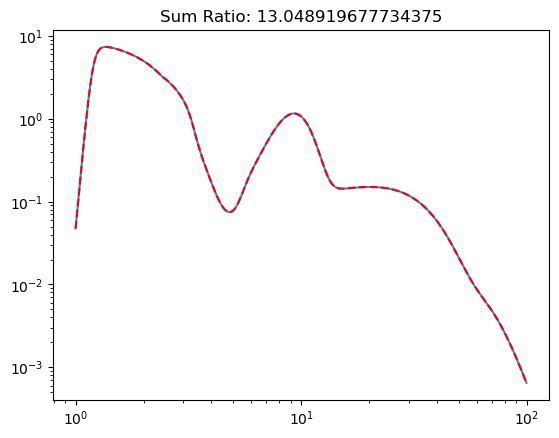

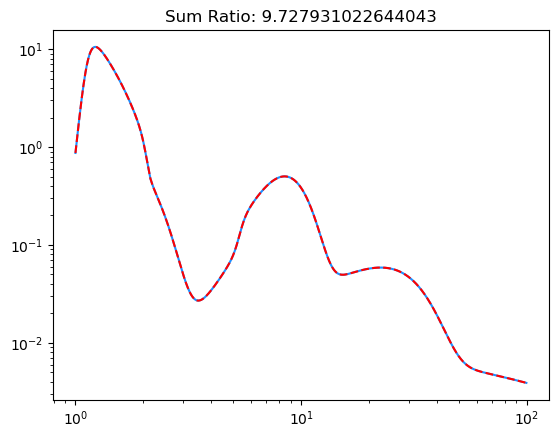

In [24]:
EG = generators.EventGenerator(*parse.parse_config("dist.ini"))
mass_dist2d = EG.variate2distribution("mass1_source")
mass_dist1d = mass_dist2d.massdist
_, var_lst = get_variables(mass_model_path, model_name = "pdb_with_NG")
var_lst.remove("m")

# import sys
# sys.path.insert(0, mass_model_path)
# from mass1d_func import pdb_with_NG

# np.random.seed(5)
random_index = np.random.randint(0, len(samples))
random_index2 = min(random_index + 2, len(samples))

error_lst = []

for i, s in enumerate(copy.deepcopy(samples)[random_index:random_index2]):
    idx = random_index + i
# for i, s in tqdm(enumerate(samples), total = len(samples)):
#     idx = i

    EG.update(**s)
    # mass_grid = 9
    mass_grid = np.logspace(0, 1.999, 1000)

    # gw-distributions
    p_m = mass_dist1d.prob(mass_grid)
    # p_m = p_m / np.sum(p_m)  # Normalize the distribution

    # my code
    vals_lst = []
    for element in var_lst:
        for new_key, old_key in conversion_dict.items():
            if element == old_key:
                vals_lst.append(merged_posterior_samples[old_key][idx])

    vals_lst = np.array(vals_lst)

    for i in range(len(var_lst)):
        if var_lst[i] in ["peak_constant1", "peak_constant2", "peak_constant_NS"]: # Known exceptions
            continue
        assert vals_lst[i] == EG[inv[var_lst[i]]]

    p_m_me = pdb_with_NG(mass_grid, *vals_lst)

    # Compute error list
    ratio = p_m/p_m_me
    error_lst.append(np.sum(ratio))

    plt.title(f"Sum Ratio: {np.sum(p_m/p_m_me)}")
    plt.plot(mass_grid, p_m_me * ratio[0], color = "dodgerblue")
    plt.plot(mass_grid, p_m, color = "red", linestyle = "dashed")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

error_lst = np.array(error_lst)

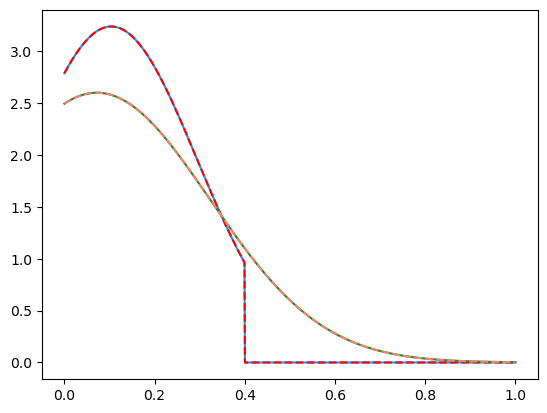

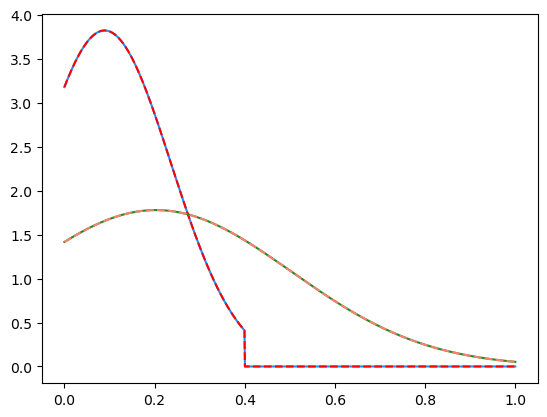

In [25]:
EG = generators.EventGenerator(*parse.parse_config("dist.ini"))
mag_dist = EG.variate2distribution("spin1_magnitude")
_, var_lst = get_variables(spin_model_path, model_name = "brokenG")
var_lst = list(filter(lambda x: x not in ["mass1_source", "mass2_source", "a1", "costilt1", "a2", "costilt2"], var_lst))

# np.random.seed(5)
random_index = np.random.randint(0, len(samples))
random_index2 = min(random_index + 2, len(samples))

error_lst_lower = []
error_lst_upper = []

for i, s in enumerate(copy.deepcopy(samples)[random_index:random_index2]):
    idx = random_index + i
# for i, s in tqdm(enumerate(samples), total = len(samples)):
#     idx = i

    EG.update(**s)
    a_grid = np.linspace(0, 1, 1000)

    # gw-distributions
    p_a_lower = mag_dist.prob(a_grid, 1)
    p_a_upper = mag_dist.prob(a_grid, 10)

    # my code
    vals_lst = []
    var_lst_copy = var_lst.copy()
    for element in var_lst:
        for new_key, old_key in conversion_dict.items():
            if element == old_key:
                if element not in var_lst_copy:
                    continue # Dont append more than once
                vals_lst.append(merged_posterior_samples[old_key][idx])
                var_lst_copy.remove(element)

    assert var_lst_copy == [], f"Not all variables were appended: {var_lst_copy}"


    vals_lst = np.array(vals_lst)
    for i in range(len(var_lst)):
        if var_lst[i] in ["mix_tilt1", "mix_tilt2"]: # Known exceptions
            continue
        assert vals_lst[i] == EG[inv[var_lst[i]]]

    _f = lambda item: vals_lst[var_lst.index(f"{item}")]


    p_a_me_lower = prob_chi_single(a_grid, _f("mu_chi1"), _f("sig_chi1"), _f("a_min"), _f("a_max_NS"))
    p_a_me_upper = prob_chi_single(a_grid, _f("mu_chi2"), _f("sig_chi2"), _f("a_min"), _f("a_max"))

    # Compute error list
    ratio_lower = p_a_lower/p_a_me_lower
    ratio_upper = p_a_me_upper/p_a_me_upper
    error_lst_lower.append(np.sum(ratio_lower))
    error_lst_upper.append(np.sum(ratio_upper))

    plt.plot(a_grid, p_a_me_lower * ratio_lower[0], color = "dodgerblue")
    plt.plot(a_grid, p_a_lower, color = "red", linestyle = "dashed")
    plt.plot(a_grid, p_a_me_upper * ratio_upper[0], color = "forestgreen")
    plt.plot(a_grid, p_a_upper, color = "salmon", linestyle = "dashed")
    plt.show()

error_lst_lower = np.array(error_lst_lower)
error_lst_upper = np.array(error_lst_upper)

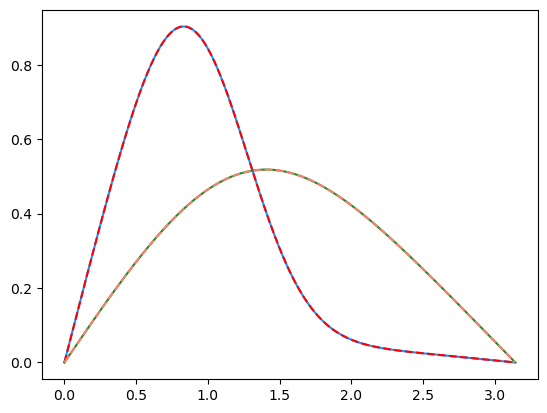

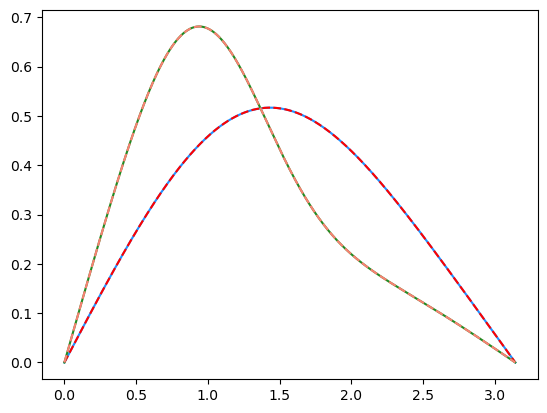

In [26]:
EG = generators.EventGenerator(*parse.parse_config("dist.ini"))
tilt_dist = EG.variate2distribution("spin1_polar_angle")
_, var_lst = get_variables(spin_model_path, model_name = "brokenG")
var_lst = list(filter(lambda x: x not in ["mass1_source", "mass2_source", "a1", "costilt1", "a2", "costilt2"], var_lst))

np.random.seed(3)
random_index = np.random.randint(0, len(samples))
random_index2 = min(random_index + 2, len(samples))

error_lst_lower = []
error_lst_upper = []

for i, s in enumerate(copy.deepcopy(samples)[random_index:random_index2]):
    idx = random_index + i
# for i, s in tqdm(enumerate(samples), total = len(samples)):
#     idx = i

    EG.update(**s)
    delta = 1e-6
    tg = np.linspace(0 + delta, np.pi - delta, 1000)
    cos_tg = np.cos(tg)

    # gw-distributions
    p_tilt_lower = tilt_dist.prob(tg, 1)
    p_tilt_upper = tilt_dist.prob(tg, 10)

    # my code
    vals_lst = []
    var_lst_copy = var_lst.copy()
    for element in var_lst:
        for new_key, old_key in conversion_dict.items():
            if element == old_key:
                if element not in var_lst_copy:
                    continue # Dont append more than once
                vals_lst.append(merged_posterior_samples[old_key][idx])
                var_lst_copy.remove(element)

    assert var_lst_copy == [], f"Not all variables were appended: {var_lst_copy}"

    vals_lst = np.array(vals_lst)
    for i in range(len(var_lst)):
        if var_lst[i] in ["mix_tilt1", "mix_tilt2"]: # Known exceptions
            continue
        assert vals_lst[i] == EG[inv[var_lst[i]]]

    _f = lambda item: vals_lst[var_lst.index(f"{item}")]


    p_costilt_me_lower = prob_costilt_single(cos_tg, _f("mix_tilt1"), _f("sig_tilt1"), _f("costilt_max"), _f("costilt_min"))
    p_tilt_me_lower = p_costilt_me_lower * np.abs((np.sin(tg)))
    p_costilt_me_upper = prob_costilt_single(cos_tg, _f("mix_tilt2"), _f("sig_tilt2"), _f("costilt_max"), _f("costilt_min"))
    p_tilt_me_upper = p_costilt_me_upper * np.abs((np.sin(tg)))

    # Compute error list
    ratio_lower = p_tilt_lower/p_tilt_me_lower
    ratio_upper = p_tilt_me_upper/p_tilt_me_upper
    error_lst_lower.append(np.sum(ratio_lower))
    error_lst_upper.append(np.sum(ratio_upper))

    plt.plot(tg, p_tilt_me_lower * ratio_lower[0], color = "dodgerblue")
    plt.plot(tg, p_tilt_lower, color = "red", linestyle = "dashed")
    plt.plot(tg, p_tilt_me_upper * ratio_upper[0], color = "forestgreen")
    plt.plot(tg, p_tilt_upper, color = "salmon", linestyle = "dashed")
    plt.show()

error_lst_lower = np.array(error_lst_lower)
error_lst_upper = np.array(error_lst_upper)

In [27]:
parse_file = parse.parse_config("dist.ini")
EG = generators.EventGenerator(*parse_file)
# print(EG.parameters)
print(EG.variates)

('mass1_source', 'mass2_source', 'z', 'spin1_magnitude', 'spin2_magnitude', 'spin1_polar_angle', 'spin2_polar_angle', 'spin1_azimuthal_angle', 'spin2_azimuthal_angle')


In [28]:
cosmo_params = ["OmegaMatter", "Ho", "OmegaRadiation", "OmegaLambda"]
redshift_lims = ["min_redshift", "max_redshift"]
known_exceptions = [*cosmo_params, *redshift_lims]

mass_dist2d = EG.variate2distribution("mass1_source")
mass_dist1d = mass_dist2d.massdist
prob_mass = []
prob_joint_mass = []


mag_dist = EG.variate2distribution("spin1_magnitude")
mag_NS = []
mag_BH = []

tilt_dist = EG.variate2distribution("spin1_polar_angle")
tilt_NS = []
tilt_BH = []

for s in tqdm(samples):
    EG.update(**s)
    lst = list(EG.parameters.keys())
    lst = [param for param in lst if param != 'Ncomp']

    # print("-----------------")
    # print(EG.parameters["notch_highmass_scale"])

    for item in lst:
        if item in known_exceptions:
            continue
        assert EG[item] == s[item], f"Mismatch for {item}: {EG[item]} vs {s[item]}"

    # Mass distribution
    mass_grid = np.logspace(0, 2, 1000)
    p_m = mass_dist1d.prob(mass_grid)
    p_m = p_m / np.sum(p_m)  # Normalize the distribution
    prob_mass.append(p_m)

    # Joint mass distribution
    joint_mass_grid = np.logspace(0, 2, 100)
    mjoint_grid = cartesian([joint_mass_grid, joint_mass_grid])
    p_m1_m2 = mass_dist2d.prob(mjoint_grid.T[0], mjoint_grid.T[1])
    p_m1_m2 = p_m1_m2 / np.sum(p_m1_m2)  # Normalize the distribution
    prob_joint_mass.append(p_m1_m2)

    # Spin Magnitude distribution
    mag_grid = np.linspace(0, 1, 1000)
    p_mag_NS = mag_dist.prob(mag_grid, 1.4)
    p_mag_BH = mag_dist.prob(mag_grid, 10)
    p_mag_NS = p_mag_NS / np.sum(p_mag_NS)  # Normalize the distribution
    p_mag_BH = p_mag_BH / np.sum(p_mag_BH)  # Normalize the distribution
    mag_NS.append(p_mag_NS)
    mag_BH.append(p_mag_BH)

    # Spin Tilt distribution
    delta = 1e-6
    tilt_grid = np.linspace(0 + delta, np.pi - delta, 1000)
    # print(tilt_dist.parameters)
    # print(tilt_dist.prob(0.3, 5))
    p_tilt_NS = tilt_dist.prob(tilt_grid, 1.4) # For lower massses
    p_tilt_BH = tilt_dist.prob(tilt_grid, 10) # For higher masses
    p_tilt_NS = p_tilt_NS / np.sum(p_tilt_NS)  # Normalize the distribution
    p_tilt_BH = p_tilt_BH / np.sum(p_tilt_BH)  # Normalize the distribution
    tilt_NS.append(p_tilt_NS)
    tilt_BH.append(p_tilt_BH)

prob_mass = np.array(prob_mass)
prob_joint_mass = np.array(prob_joint_mass)
p_mag_NS = np.array(mag_NS)
p_mag_BH = np.array(mag_BH)
tilt_NS = np.array(tilt_NS)
tilt_BH = np.array(tilt_BH)

100%|██████████| 5000/5000 [00:25<00:00, 196.86it/s]


In [29]:
for p_m in prob_mass:
    assert np.isclose(np.sum(p_m), 1.0), f"Probability mass does not sum to 1: {np.sum(p_m)}"

for p_m1_m2 in prob_joint_mass:
    assert np.isclose(np.sum(p_m1_m2), 1.0), f"Probability mass does not sum to 1: {np.sum(p_m1_m2)}"

for p_mag in p_mag_NS:
    assert np.isclose(np.sum(p_mag), 1.0), f"Probability mass does not sum to 1: {np.sum(p_mag)}"

for p_mag in p_mag_BH:
    assert np.isclose(np.sum(p_mag), 1.0), f"Probability mass does not sum to 1: {np.sum(p_mag)}"

for p_tilt in tilt_NS:
    assert np.isclose(np.sum(p_tilt), 1.0), f"Probability mass does not sum to 1: {np.sum(p_tilt)}"

for p_tilt in tilt_BH:
    assert np.isclose(np.sum(p_tilt), 1.0), f"Probability mass does not sum to 1: {np.sum(p_tilt)}"

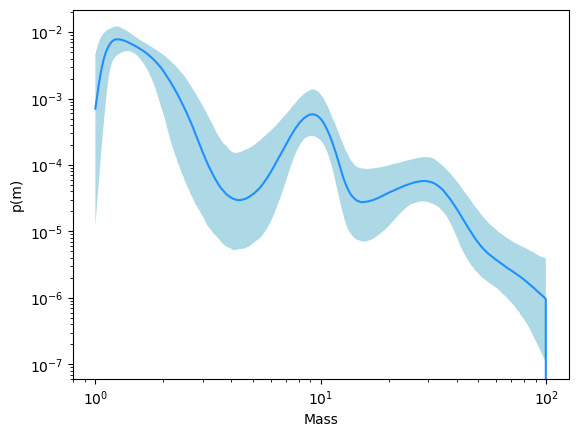

In [30]:
# Functional form checked
plt.figure()
p50 = np.percentile(prob_mass, 50, axis=0)
p95 = np.percentile(prob_mass, 95, axis=0)
p5 = np.percentile(prob_mass, 5, axis=0)
plt.fill_between(mass_grid, p5, p95, facecolor="lightblue", alpha=1)
plt.plot(mass_grid, p50.squeeze(), color="dodgerblue")
plt.xscale("log");plt.yscale("log")
plt.xlabel("Mass")
plt.ylabel("p(m)")
plt.show()

/var/folders/hr/fxn20ncj0qq2_mtm8k66bl7r0000gn/T/ipykernel_55389/2784863700.py:5: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(joint_mass_grid, joint_mass_grid, p_joint, levels=levs, cmap="viridis", norm=mpl.colors.LogNorm())


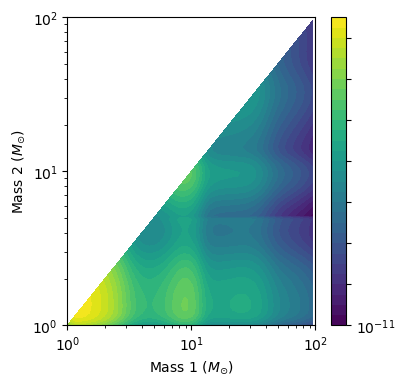

In [31]:
p_joint = np.median(prob_joint_mass, axis=0).reshape(len(joint_mass_grid), len(joint_mass_grid)).T

plt.figure(figsize=(4,4))
levs = np.geomspace(1e-11, 2e-2, num=31, endpoint = True).tolist()
plt.contourf(joint_mass_grid, joint_mass_grid, p_joint, levels=levs, cmap="viridis", norm=mpl.colors.LogNorm())
plt.xscale("log") ; plt.yscale("log")
plt.xlabel(r"Mass 1 ($M_{\odot}$)") ; plt.ylabel(r"Mass 2 ($M_{\odot}$)")
plt.colorbar()
plt.show()

Text(0, 0.5, 'p(a)')

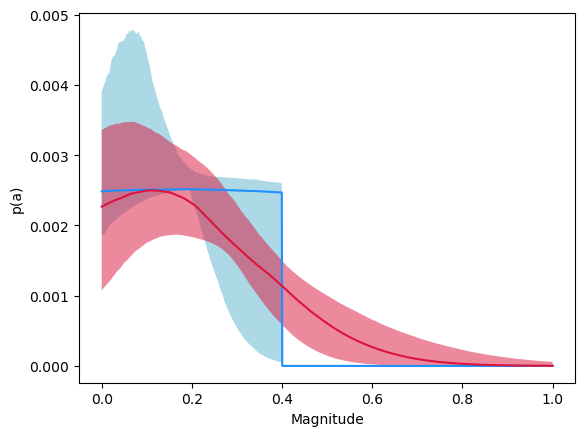

In [32]:
plt.figure()
p50 = np.percentile(p_mag_NS, 50, axis=0)
p95 = np.percentile(p_mag_NS, 95, axis=0)
p5 = np.percentile(p_mag_NS, 5, axis=0)
plt.fill_between(mag_grid, p5, p95, facecolor="lightblue", alpha=1)
plt.plot(mag_grid, p50.squeeze(), color="dodgerblue")
p50 = np.percentile(p_mag_BH, 50, axis=0)
p95 = np.percentile(p_mag_BH, 95, axis=0)
p5 = np.percentile(p_mag_BH, 5, axis=0)
plt.fill_between(mag_grid, p5, p95, facecolor="crimson", alpha=0.5)
plt.plot(mag_grid, p50.squeeze(), color="crimson")
plt.xlabel("Magnitude") ; plt.ylabel("p(a)")

In [33]:
# p(cos(theta)) = p(theta) * |dtheta/dcostheta|

jac = lambda tg: np.abs(1/(np.sin(tg))) # Add jitter for stability

costilt_NS = np.array([tilt * jac(tilt_grid) for tilt in tilt_NS])
costilt_BH = np.array([tilt * jac(tilt_grid) for tilt in tilt_BH])
cos_tilt_grid = np.cos(tilt_grid)
assert np.isclose(cos_tilt_grid.min(), -1)
assert np.isclose(cos_tilt_grid.max(), 1)

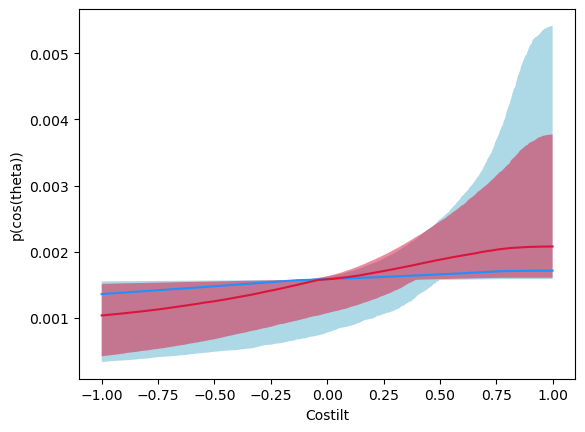

In [34]:
plt.figure()
p50 = np.percentile(costilt_NS, 50, axis=0)
p95 = np.percentile(costilt_NS, 95, axis=0)
p5 = np.percentile(costilt_NS, 5, axis=0)
plt.fill_between(cos_tilt_grid, p5, p95, facecolor="lightblue", alpha=1)
plt.plot(cos_tilt_grid, p50.squeeze(), color="dodgerblue")
p50 = np.percentile(costilt_BH, 50, axis=0)
p95 = np.percentile(costilt_BH, 95, axis=0)
p5 = np.percentile(costilt_BH, 5, axis=0)
plt.fill_between(cos_tilt_grid, p5, p95, facecolor="crimson", alpha=0.5)
plt.plot(cos_tilt_grid, p50.squeeze(), color="crimson")
plt.xlabel("Costilt") ; plt.ylabel("p(cos(theta))")
plt.show()